In [1]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Conv1D, concatenate
from tensorflow.keras.layers import ZeroPadding1D, Reshape, Input, Dropout, PReLU
from tensorflow.keras.models import Sequential, Model

### Load data

In [4]:
data_dir = pathlib.Path('/project/informatics_lab/precip_rediagnosis/')

In [5]:
data = pd.read_csv(
    data_dir / 'prd_merged_015H_20200215T0300Z_20200217T0900Z.csv',
    index_col=0)

In [6]:
target_parameter = 'rainfall_rate_composite'
profile_features = ['air_temperature', 'relative_humidity']
single_lvl_features = ['air_pressure_at_sea_level'] 

### Data pre-processing

In [7]:
# drop NaN values in the dataset
data = data.dropna()

# drop data points with zero precip in the radar data
data = data[data[target_parameter]>0]

In [8]:
# Get a list of columns names for profile features
prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

features = data[prof_feature_columns + single_lvl_features]

target = data[[target_parameter]]

In [9]:
# data_control uses only the control member

# data_control = data[data['realization']==0]

# # Get a list of columns names for profile features
# prof_feature_columns = [s for s in data.columns for vars in profile_features if s.startswith(vars)]

# features = data_control[prof_feature_columns + single_lvl_features]

# target = data_control[[target_parameter]]

In [10]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,281.403148,2.469136,271.812500,279.875000,281.625000,283.250000,288.125000
air_temperature_10.0,153522.0,281.434214,2.473669,271.875000,279.937500,281.625000,283.312500,288.187500
air_temperature_20.0,153522.0,281.495603,2.488522,272.000000,280.000000,281.625000,283.375000,288.375000
air_temperature_30.0,153522.0,281.431163,2.492926,271.937500,279.875000,281.562500,283.312500,288.312500
air_temperature_50.0,153522.0,281.298198,2.511828,271.750000,279.750000,281.375000,283.250000,288.125000
...,...,...,...,...,...,...,...,...
relative_humidity_4500.0,153522.0,0.664071,0.258861,0.007812,0.489258,0.765625,0.875000,1.012695
relative_humidity_5000.0,153522.0,0.636342,0.267978,0.007812,0.461914,0.746094,0.852539,1.004883
relative_humidity_5500.0,153522.0,0.606278,0.274481,0.006836,0.412109,0.723633,0.829102,1.005859
relative_humidity_6000.0,153522.0,0.570755,0.278880,0.006836,0.343750,0.691406,0.802734,0.986328


In [11]:
standardScaler = StandardScaler()

features = pd.DataFrame(standardScaler.fit_transform(features), 
                                columns=features.columns,
                                index=features.index)
features.describe().T

,count,mean,std,min,25%,50%,75%,max
air_temperature_5.0,153522.0,-5.017796e-15,1.000003,-3.884224,-0.618902,0.089850,0.747977,2.722358
air_temperature_10.0,153522.0,-1.889819e-15,1.000003,-3.864399,-0.605060,0.077127,0.759314,2.730077
air_temperature_20.0,153522.0,8.673026e-15,1.000003,-3.815772,-0.601002,0.051998,0.755228,2.764459
air_temperature_30.0,153522.0,-9.964501e-15,1.000003,-3.808254,-0.624234,0.052684,0.754673,2.760355
air_temperature_50.0,153522.0,2.849539e-15,1.000003,-3.801307,-0.616365,0.030576,0.777047,2.717871
...,...,...,...,...,...,...,...,...
relative_humidity_4500.0,153522.0,-7.109037e-17,1.000003,-2.535187,-0.675321,0.392310,0.814836,1.346765
relative_humidity_5000.0,153522.0,-7.701457e-17,1.000003,-2.345456,-0.650905,0.409556,0.806773,1.375268
relative_humidity_5500.0,153522.0,-4.857842e-16,1.000003,-2.183918,-0.707405,0.427553,0.811802,1.455776
relative_humidity_6000.0,153522.0,3.080583e-16,1.000003,-2.022093,-0.813992,0.432628,0.831827,1.490154


In [12]:
processed_data = pd.concat([features, target], axis=1, sort=False)
processed_data

,air_temperature_5.0,air_temperature_10.0,air_temperature_20.0,air_temperature_30.0,air_temperature_50.0,air_temperature_75.0,air_temperature_100.0,air_temperature_150.0,air_temperature_200.0,air_temperature_250.0,...,relative_humidity_3250.0,relative_humidity_3500.0,relative_humidity_3750.0,relative_humidity_4000.0,relative_humidity_4500.0,relative_humidity_5000.0,relative_humidity_5500.0,relative_humidity_6000.0,air_pressure_at_sea_level,rainfall_rate_composite
0,0.950478,0.936178,0.905921,0.905099,0.926341,0.964120,0.998305,1.081785,1.155757,1.206579,...,0.016760,-0.611374,-0.999043,-1.364747,-1.169525,0.606342,0.783339,0.863343,1.602590,0.055013
1,0.899853,0.885645,0.855690,0.854957,0.876576,0.889926,0.900185,0.960767,1.036554,1.112492,...,-1.874734,-2.200925,-2.265530,-2.364876,-2.395603,-0.257332,0.804687,0.859841,1.582919,0.055013
2,1.152978,1.138307,1.106844,1.105667,1.075635,1.137240,1.194545,1.251211,1.298800,1.347711,...,-1.796249,-2.263722,-2.367793,-2.196227,-0.728136,0.792196,0.826034,0.894858,1.589476,0.055013
3,1.203604,1.188839,1.157075,1.155809,1.175165,1.186702,1.194545,1.251211,1.274959,1.300667,...,-0.301105,-1.255044,-1.600821,-1.513786,-0.535737,0.631852,0.772666,0.845834,1.585378,0.055013
4,0.798602,0.784580,0.755228,0.754673,0.777047,0.791000,0.802065,0.863952,0.893512,0.900795,...,-1.513702,-1.753496,-1.758148,-1.878539,-2.108889,0.478796,0.815360,0.908865,1.627998,0.055013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211387,-0.542964,-0.554528,-0.601002,-0.599163,-0.616365,-0.618689,-0.620674,-0.636677,-0.632279,-0.651651,...,-1.321413,-1.667150,-1.809280,-1.647136,-1.052576,-0.833115,-0.426334,-0.295734,-0.708723,0.486349
211388,-0.087338,-0.099736,-0.098695,-0.097742,-0.118718,-0.124061,-0.130074,-0.152603,-0.203150,-0.228257,...,-1.603960,-2.259797,-2.281263,-2.121707,-1.761815,-1.715010,-1.148580,-0.236204,-0.756261,0.486349
211389,-0.264526,-0.276600,-0.299618,-0.298310,-0.317777,-0.321912,-0.326314,-0.346233,-0.346193,-0.369388,...,-1.317489,-1.415962,-1.408095,-1.388280,-1.346834,-1.230332,-1.013381,-0.891030,-0.784947,0.486349
211390,-0.163276,-0.175535,-0.199156,-0.223097,-0.243130,-0.272449,-0.277254,-0.297825,-0.298512,-0.322345,...,-0.312878,-0.583901,-0.947911,-1.156877,-0.969579,-0.614463,-0.397871,-0.201187,-0.771833,0.486349


Split the dataset into 60/20/20 subsets for training, testing and validation

In [14]:
# Height profiles data
X_train_prof, X_test_prof, y_train, y_test = train_test_split(
    features[prof_feature_columns],
    target,
    test_size=0.2,
    random_state=1
)

# Single level data
X_train_singlvl, X_test_singlvl, y_train, y_test = train_test_split(
    features[single_lvl_features],
    target,
    test_size=0.2,
    random_state=1
)

# y_test and y_train is the same in both of these, given that the random state is set

In [12]:
# reshape height profile variables 
X_train_prof = np.transpose(X_train_prof.to_numpy().reshape(X_train_prof.shape[0], 2, 33), (0, 2, 1))
X_test_prof = np.transpose(X_test_prof.to_numpy().reshape(X_test_prof.shape[0], 2, 33), (0, 2, 1))

In [14]:
def build_model(nprof_features, nheights, nsinglvl_features):
    
    profile_input = Input(shape=(nheights, nprof_features), name='profile_input')
    prof_size = nheights*nprof_features

    out = ZeroPadding1D(padding=1)(profile_input)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    ident = out
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    out = ZeroPadding1D(padding=1)(out)
    out = Conv1D(32, 3, strides=1, activation='relu', use_bias=False, kernel_initializer='glorot_uniform', bias_initializer='zeros')(out)
    x = tf.keras.layers.add([out, ident])
    out = Flatten()(x)
    out = Dense(prof_size, use_bias=False, activation='relu')(out)

    if nsinglvl_features > 0:
        surf_input = Input(shape=(nsinglvl_features,), name='surf_input')
        flat_profs = Flatten()(profile_input)
        raw_in = tf.keras.layers.concatenate([flat_profs, surf_input])
        raw_size = (nheights*nprof_features)+nsinglvl_features
        
        out = tf.keras.layers.concatenate([out, surf_input])
        x = tf.keras.layers.add([out, raw_in])
        x = Dense(1024, use_bias=False, activation='relu')(x)
        x = Dense(1024, use_bias=False, activation='relu')(x)
        
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(x)
        model = Model(inputs=[profile_input, surf_input], outputs=[main_output])
    
    else:
        main_output = Dense(1, use_bias=True, activation='linear', name='main_output')(out)
        model = Model(inputs=[profile_input], outputs=[main_output])
        
    return model

In [16]:
nprof_features = len(profile_features)
nheights = len(prof_feature_columns)//len(profile_features)
nsinglvl_features = len(single_lvl_features)

In [ ]:
model = build_model(nprof_features, nheights, nsinglvl_features)
model.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer)

In [24]:
if nsinglvl_features > 0:
    X_train = [X_train_prof, X_train_singlvl]
    X_test = [X_test_prof, X_test_singlvl]
else:
    X_train = X_train_prof
    X_test = X_test_prof

In [25]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.25, verbose=True)

Epoch 1/100
2879/2879 [==============================] - 14s 5ms/step - loss: 16.1702 - val_loss: 15.3183
Epoch 2/100
2879/2879 [==============================] - 14s 5ms/step - loss: 15.0500 - val_loss: 14.6509
Epoch 3/100
2879/2879 [==============================] - 14s 5ms/step - loss: 14.3806 - val_loss: 14.1556
Epoch 4/100
2879/2879 [==============================] - 15s 5ms/step - loss: 13.8104 - val_loss: 13.4649
Epoch 5/100
2879/2879 [==============================] - 14s 5ms/step - loss: 13.3672 - val_loss: 13.2386
Epoch 6/100
2879/2879 [==============================] - 15s 5ms/step - loss: 12.9852 - val_loss: 12.9025
Epoch 7/100
2879/2879 [==============================] - 15s 5ms/step - loss: 12.6940 - val_loss: 12.7321
Epoch 8/100
2879/2879 [==============================] - 15s 5ms/step - loss: 12.4517 - val_loss: 12.5685
Epoch 9/100
2879/2879 [==============================] - 15s 5ms/step - loss: 12.2482 - val_loss: 12.2311
Epoch 10/100
2879/2879 [======================

2879/2879 [==============================] - 14s 5ms/step - loss: 8.4185 - val_loss: 10.7359
Epoch 79/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.4053 - val_loss: 10.5668
Epoch 80/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.3745 - val_loss: 10.7320
Epoch 81/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.3729 - val_loss: 10.5592
Epoch 82/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.3520 - val_loss: 10.4777
Epoch 83/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.3191 - val_loss: 10.6014
Epoch 84/100
2879/2879 [==============================] - 15s 5ms/step - loss: 8.2821 - val_loss: 10.6783
Epoch 85/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.2880 - val_loss: 10.5695
Epoch 86/100
2879/2879 [==============================] - 14s 5ms/step - loss: 8.2501 - val_loss: 10.6036
Epoch 87/100
2879/2879 [==============================] - 1

## Evaluation

In [83]:
training_hist_df = pd.DataFrame(history.history)
training_hist_df['epoch'] = history.epoch

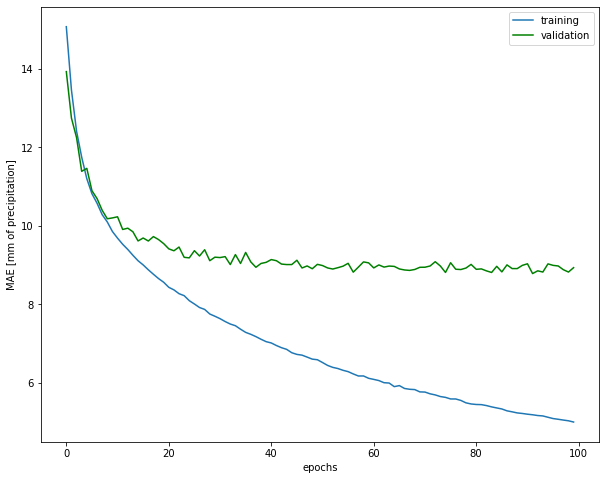

In [84]:
plt.figure(figsize=(10, 8))
plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.show()

In [86]:
y_pred = model.predict(X_test)

In [87]:
from sklearn.metrics import mean_absolute_error, r2_score
error = mean_absolute_error(y_test, y_pred)
print(f'MAE: {error:.3f}')

rsqrd = r2_score(y_test, y_pred)
print(f'R-squared score: {rsqrd:.3f}')

MAE: 9.001
R-squared score: 0.727


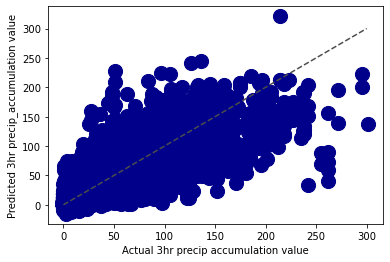

In [88]:
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")
plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

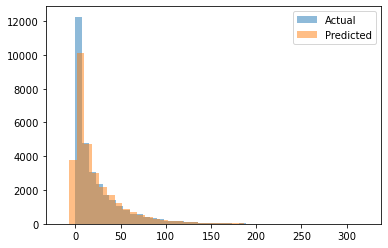

In [90]:
plt.figure(figsize=(10, 8))
plt.hist(y_test, alpha=0.5, bins=40, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=40, label='Predicted')
plt.legend()
plt.show()

## Control member only plots

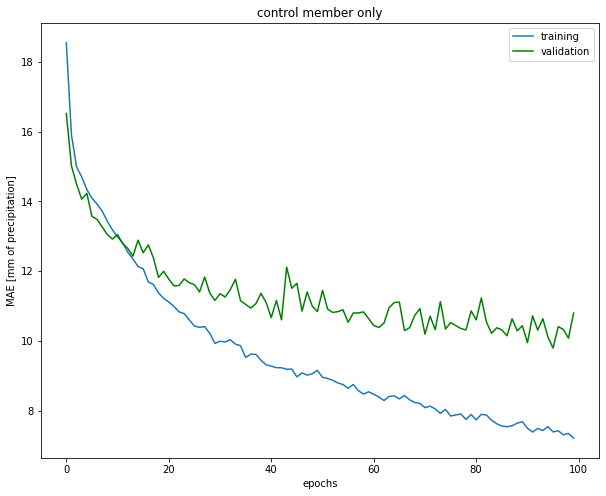

In [122]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))

plt.plot(training_hist_df.epoch, training_hist_df.loss, label='training')
plt.plot(training_hist_df.epoch, training_hist_df.val_loss, c='g', label='validation')
plt.legend()
plt.ylabel('MAE [mm of precipitation]')
plt.xlabel('epochs')
plt.title('control member only')
plt.show()

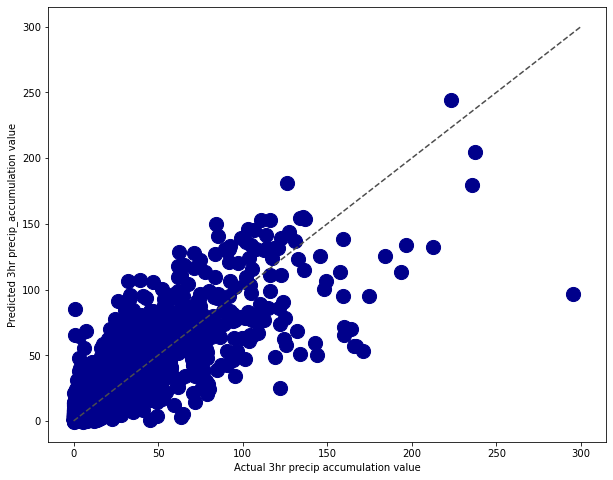

In [123]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 8))

plt.scatter(y_test, y_pred, s=200, c='darkblue')
plt.gca().plot([0, 300], [0, 300], ls="--", c=".3")

plt.xlabel('Actual 3hr precip accumulation value')
plt.ylabel('Predicted 3hr precip_accumulation value')
plt.show()

In [124]:
from sklearn.metrics import mean_absolute_error, r2_score
error = mean_absolute_error(y_test, y_pred)
print(f'MAE: {error:.3f}')

rsqrd = r2_score(y_test, y_pred)
print(f'R-squared score: {rsqrd:.3f}')

MAE: 11.381
R-squared score: 0.669


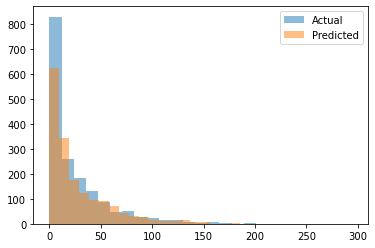

In [125]:
plt.figure(figsize=(10, 8))
plt.hist(y_test, alpha=0.5, bins=25, label='Actual')
plt.hist(y_pred, alpha=0.5, bins=25, label='Predicted')
plt.legend()
plt.show()